In [4]:
# imports
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt

#### Loading the images from the data folder 

In [5]:
def load_dataset_with_names(folder_path):
    dataset = []

    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)

        if file_path.endswith(('.png')):
            img = Image.open(file_path)

            img_array = np.array(img)

            parts = filename.split('.')
            subject = parts[0]
            emotion = parts[1]

            img_info = {'image': img_array, 'subject': subject, 'emotion': emotion}

            dataset.append(img_info)

    return dataset


In [6]:
folder_path = 'data/'
image_dataset_raw = load_dataset_with_names(folder_path)

In [7]:
image_dataset_raw[0]

{'image': array([[130, 130, 130, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        ...,
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        [ 68,  68,  68, ...,  68,  68,  68]], dtype=uint8),
 'subject': 'subject01',
 'emotion': 'centerlight'}

In [8]:
print(f"Number of images: {len(image_dataset_raw)}")
print(f"shape of Images: {image_dataset_raw[0]['image'].shape}")

Number of images: 165
shape of Images: (243, 320)


#### Preparing the training & testing dataset
* we made use of the subjects' pictures with no glasses for the train data and the whole dataset (165 of it) for the testing 

In [9]:
train_data = [image_dataset_raw[i]['image'] for i in range(0, len(image_dataset_raw)) if image_dataset_raw[i]['emotion'] == 'noglasses']
test_data = image_dataset_raw.copy()

#### Scaling the pixel values

In [10]:
train_data = np.array(train_data) / 255

for image in test_data:
    image['image'] = np.array(image['image']) / 255

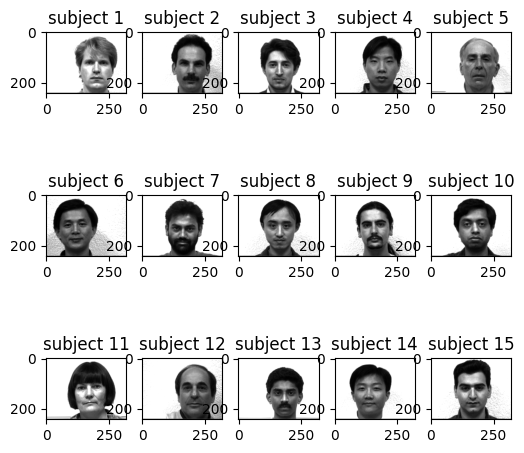

In [11]:
num_images = len(train_data)
num_rows = 3
num_cols = 5
fig, axes = plt.subplots(num_rows, num_cols, figsize=(6, 6))
for i, ax in enumerate(axes.flat):
    if i < num_images:
        ax.imshow(train_data[i], cmap='gray')
        ax.set_title(f"subject {i+1}")
    else:
        ax.axis('off')

plt.show()

#### Flattening the train_data & test_data images


In [12]:
train_data = np.array([image.reshape(-1) for image in train_data])
for image in test_data:
    image['image'] = np.array(image['image']).reshape(-1)
print(f"Train - {train_data.shape}")
print(f"Test - {test_data[0]['image'].shape}")

Train - (15, 77760)
Test - (77760,)


#### Calculating the mean face

In [13]:
mean_face = np.mean(train_data, axis=0)
mean_face.shape

(77760,)

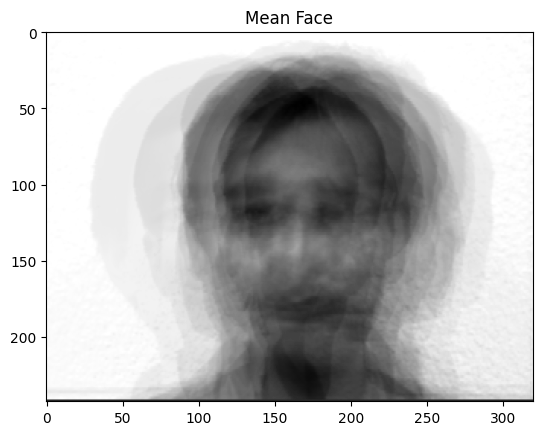

In [14]:
img_matrix = mean_face.reshape((243, 320))
plt.imshow(img_matrix, cmap='gray')
plt.title('Mean Face')
plt.show()

#### Normalizing/Mean centering the train_data

In [15]:
train_data_centered = train_data - mean_face

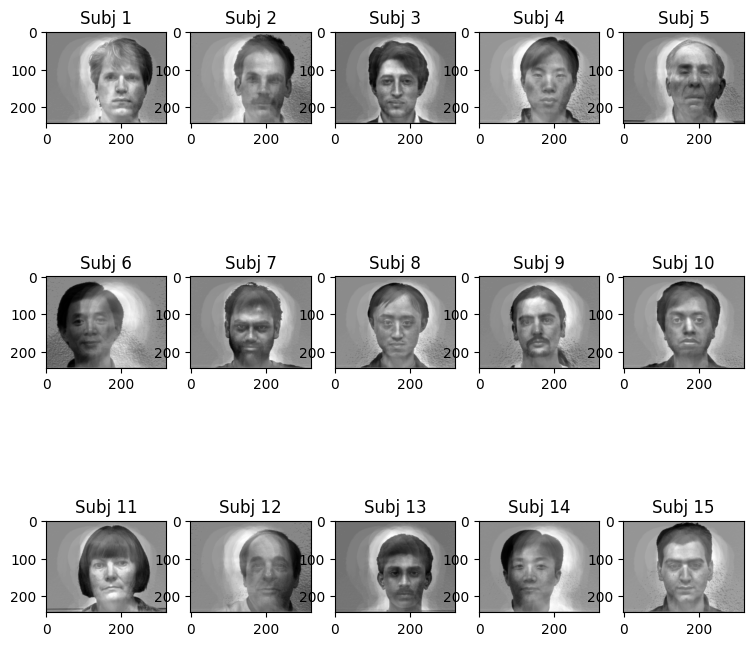

In [16]:
img_shape = (243, 320) 
img_matrices = [img_vector.reshape(img_shape) for img_vector in train_data_centered]
num_images = len(img_matrices)
fig, axes = plt.subplots(3, 5, figsize=(9, 9))

for i, (img_matrix, ax) in enumerate(zip(img_matrices, axes.flat)):
    ax.imshow(img_matrix, cmap='gray')
    ax.set_title(f'Subj {i + 1}')

plt.show()

#### Computing the covariance  matrix: $ cov = AA^T $


In [17]:
cov = train_data_centered @ train_data_centered.T

In [25]:
cov.shape

(15, 15)

#### Computing the eigen values and eigen vectors

In [21]:
eigenvalues, eigenvectors = np.linalg.eig(cov)

In [24]:
eigenvectors.shape

(15, 15)

#### Sorting the eigenvectors based on their corresponding eigenvalues in descending order.

In [27]:
sorted_indices = np.argsort(eigenvalues)[::-1]
sorted_eigenvalues = eigenvalues[sorted_indices]
sorted_eigenvectors = eigenvectors[:, sorted_indices]

#### Selecting Top Eigenvectors: 
*   Choose the top k eigenvectors (principal components) corresponding to the largest eigenvalues.
*   Choosing enough to capture a high percentage of the total variance ( for e.g., 95%).

In [45]:
cumulative_variance = np.cumsum(sorted_eigenvalues) / np.sum(sorted_eigenvalues)
desired_variance_explained = 0.9
k = np.argmax(cumulative_variance >= desired_variance_explained) + 1
top_k_eigenvectors = sorted_eigenvectors[:, :k]

print(f"Selected {k} eigenvectors")

Selected 9 eigenvectors


#### Projecting Faces


In [46]:
projected_train_data = np.dot(top_k_eigenvectors.T, train_data_centered)

In [47]:
projected_train_data.shape

(9, 77760)

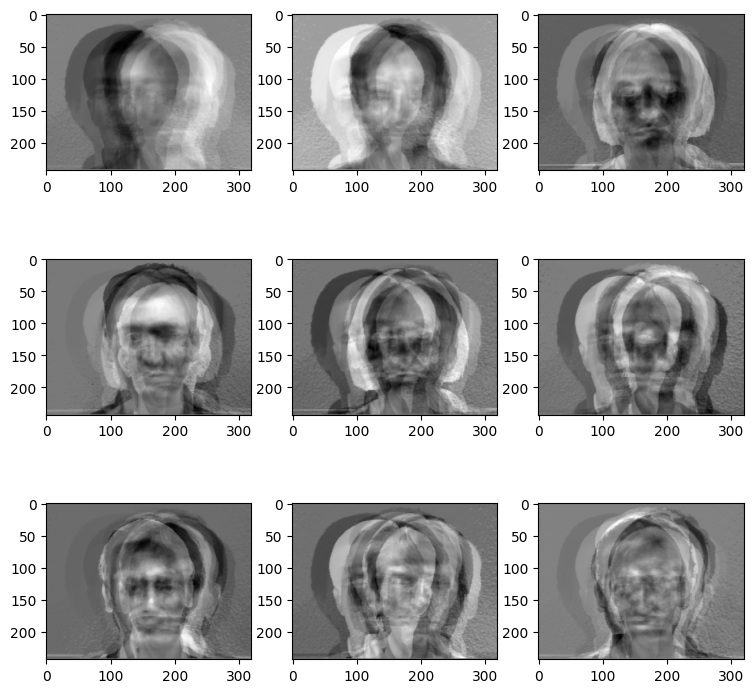

In [63]:
img_shape = (243, 320) 
img_matrices = [img_vector.reshape(img_shape) for img_vector in projected_train_data]
num_images = len(img_matrices)
fig, axes = plt.subplots(3, 3, figsize=(9, 9))

for i, (img_matrix, ax) in enumerate(zip(img_matrices, axes.flat)):
    ax.imshow(img_matrix, cmap='gray')

plt.show()